# Installs & Imports

In [ ]:
!pip install -q silence-tensorflow tensorflow==2.8.1 pennylane

In [ ]:
# Import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import chain
from wordcloud import WordCloud

import os
import sys
import time
import random
import joblib
import pickle
import math
import re
import string
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pennylane as qml

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set random seeds
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

from silence_tensorflow import silence_tensorflow
silence_tensorflow()

Mounted at /content/drive


# Loading the Data

In [ ]:
# Load the SARC dataset
df = pd.read_csv('/content/drive/My Drive/Datasets/SARC/train-balanced-sarcasm.csv')

In [ ]:
# Examine the dataset
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [ ]:
# Examine the shapes
print(f"There are {df.shape[0]} rows")
print(f"There are {df.shape[1]} columns")

There are 1010826 rows
There are 10 columns


# Exploring the Data

In [ ]:
# Quick info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [ ]:
# Remove rows with missing comments
df = df.dropna(subset=['comment'])

# Confirm the removal
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010773 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010773 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010773 non-null  object
 3   subreddit       1010773 non-null  object
 4   score           1010773 non-null  int64 
 5   ups             1010773 non-null  int64 
 6   downs           1010773 non-null  int64 
 7   date            1010773 non-null  object
 8   created_utc     1010773 non-null  object
 9   parent_comment  1010773 non-null  object
dtypes: int64(4), object(6)
memory usage: 84.8+ MB


In [ ]:
# Function to examine sarcastic comments
def sample_sarcastic_comments(df, n=10):
    # Filter for sarcastic comments
    sarcastic_comments = df[df['label'] == 1]

    # Sample n sarcastic comments randomly
    sample_comments = sarcastic_comments.sample(n)

    # Display the sampled comments
    print(sample_comments[['comment']])

# Call the function
sample_sarcastic_comments(df)

                                                  comment
470706       He took a step after the contact, no penalty
810048  Basically, he's not paying to progress, and th...
475690                        YOU CHOSE TO LIMIT YOURSELF
300732  But, how come the jet fuel didn't melt the beams?
204322  TIL, this is all Obama's fault and W was the b...
819422           I liked the ending, the rest needs work.
131032  But that doesn't explain how his short range a...
113187  You underestimate the power of in-vitro fertil...
843985  Don't worry he's just keeping his Heat flair u...
162133  But those hearings and investigations didn't e...


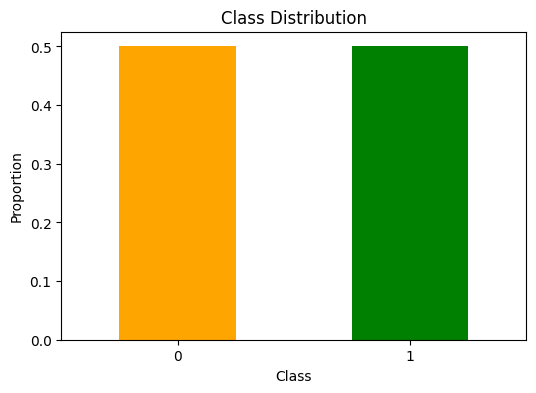

In [ ]:
# Function to plot class distribution
def plot_class_distribution(df, column='label', colors=None):
    class_counts = df[column].value_counts(normalize=True)

    plt.figure(figsize=(6, 4))
    if colors is None:
        colors = plt.cm.tab10(range(len(class_counts)))
    class_counts.plot(kind='bar', color=colors)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Proportion')
    plt.xticks(ticks=range(len(class_counts)), labels=class_counts.index, rotation=0)
    plt.show()

# Call the function
plot_class_distribution(df, colors=['orange', 'green'])

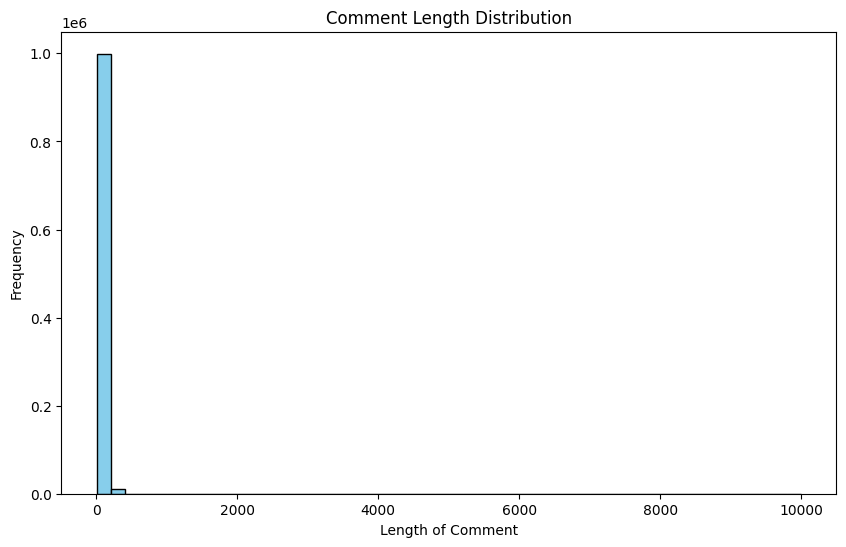

In [ ]:
# Function to plot comment length distribution
def plot_comment_length_distribution(df, text_column='comment'):
    df['comment_length'] = df[text_column].str.len()

    plt.figure(figsize=(10, 6))
    plt.hist(df['comment_length'].dropna(), bins=50, color='skyblue', edgecolor='black')
    plt.title('Comment Length Distribution')
    plt.xlabel('Length of Comment')
    plt.ylabel('Frequency')
    plt.show()

# Call the function
plot_comment_length_distribution(df)

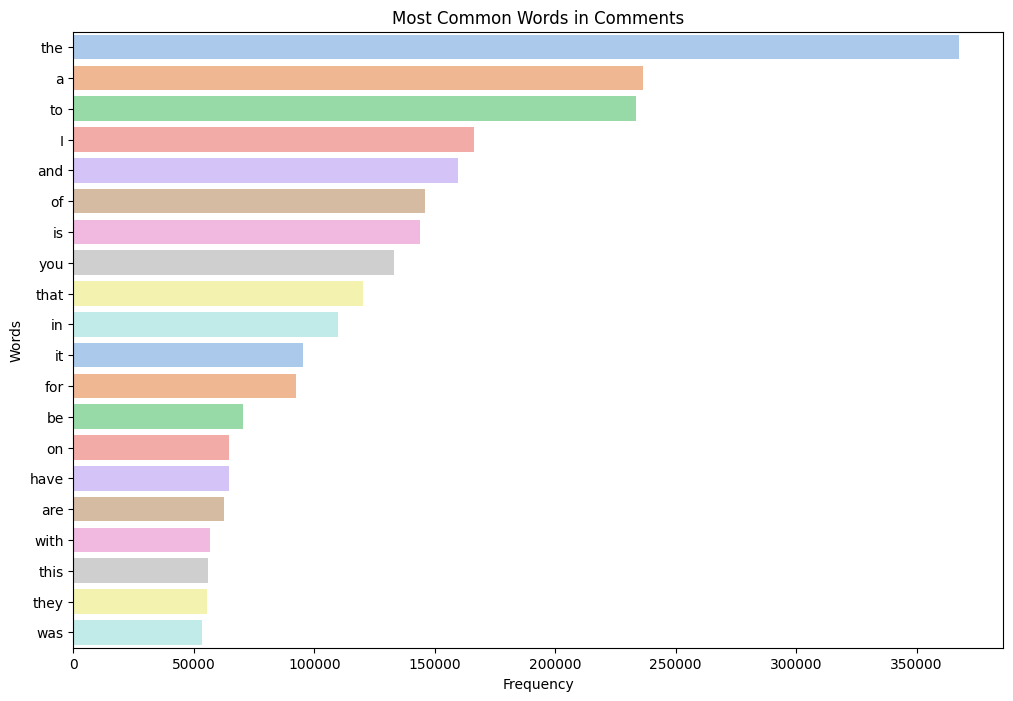

In [ ]:
# Function to plot word frequency
def plot_word_frequency(df, text_column='comment', n_most_common=20):
    # Concatenate all comments into a single string
    all_words = ' '.join(df[text_column].dropna()).split()
    word_freq = Counter(all_words)

    # Get the most common words
    most_common_words = word_freq.most_common(n_most_common)
    words, counts = zip(*most_common_words)

    # Create color palette
    palette = sns.color_palette('pastel', n_most_common)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=list(counts), y=list(words), hue=list(words), palette=palette)
    plt.title('Most Common Words in Comments')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

# Call the function
plot_word_frequency(df)

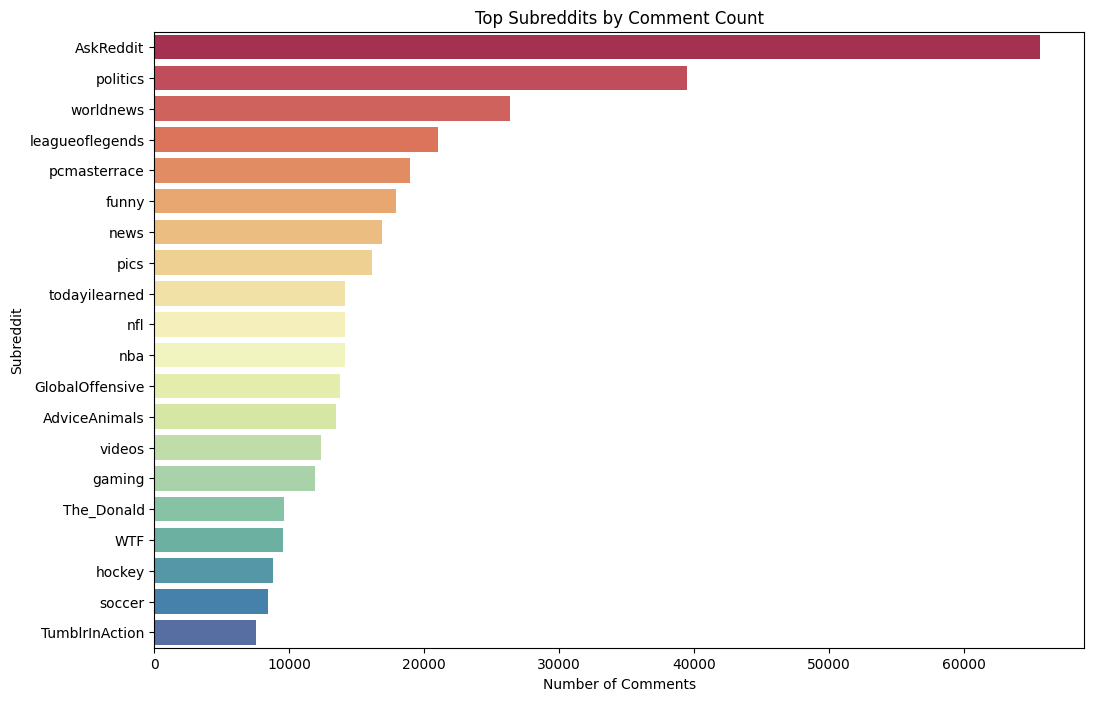

In [ ]:
# Function to plot subreddit distribution
def plot_subreddit_distribution(df, subreddit_column='subreddit', top_n=20):
    # Get the top N subreddits based on comment count
    subreddit_counts = df[subreddit_column].value_counts().head(top_n)

    # Create a color palette
    palette = sns.color_palette('Spectral', n_colors=top_n)

    plt.figure(figsize=(12, 8))
    sns.barplot(y=subreddit_counts.index, x=subreddit_counts.values, hue=subreddit_counts.index, palette=palette, orient='h')
    plt.title('Top Subreddits by Comment Count')
    plt.xlabel('Number of Comments')
    plt.ylabel('Subreddit')
    plt.show()

# Call the function
plot_subreddit_distribution(df)

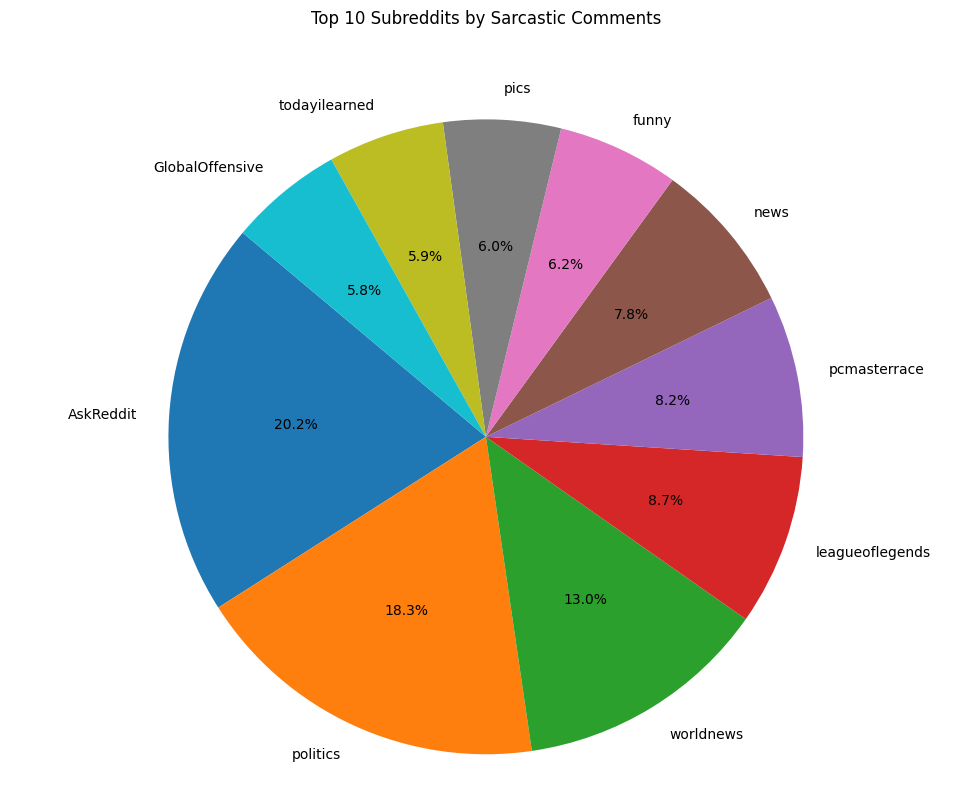

In [ ]:
# Function to plot subreddits with most sarcastic comments
def plot_pie_top_sarcastic_subreddits(df, n=10):
    # Filter for sarcastic comments
    sarcastic_comments = df[df['label'] == 1]

    # Count the occurrences of each subreddit in the sarcastic comments
    top_subreddits = sarcastic_comments['subreddit'].value_counts().head(n)

    # Plot the data as a pie chart
    plt.figure(figsize=(10, 8))
    plt.pie(top_subreddits, labels=top_subreddits.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Top {n} Subreddits by Sarcastic Comments', y=1.08)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# Call the function
plot_pie_top_sarcastic_subreddits(df)

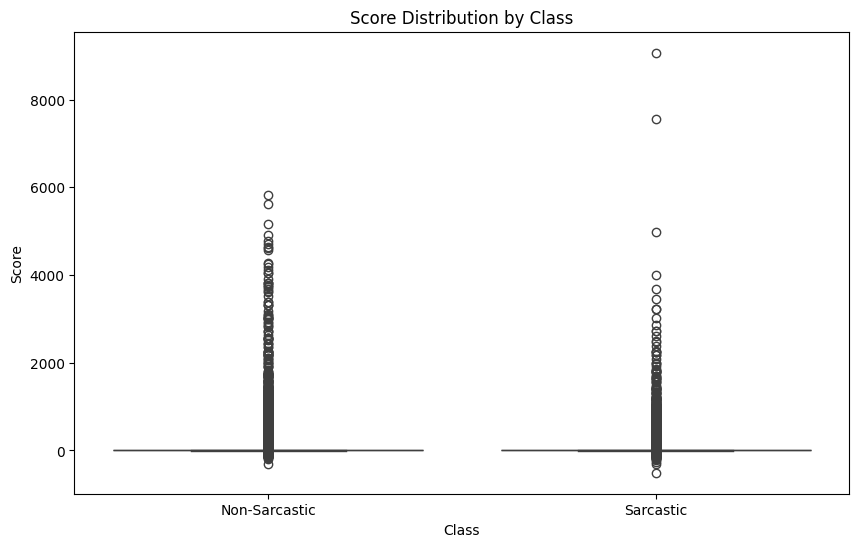

In [ ]:
# Function to plot score distribution
def plot_score_distribution_by_class(df, score_column='score', class_column='label'):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=class_column, y=score_column, data=df)
    plt.title('Score Distribution by Class')
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.xticks(ticks=[0, 1], labels=['Non-Sarcastic', 'Sarcastic'])
    plt.show()

# Call the function
plot_score_distribution_by_class(df)

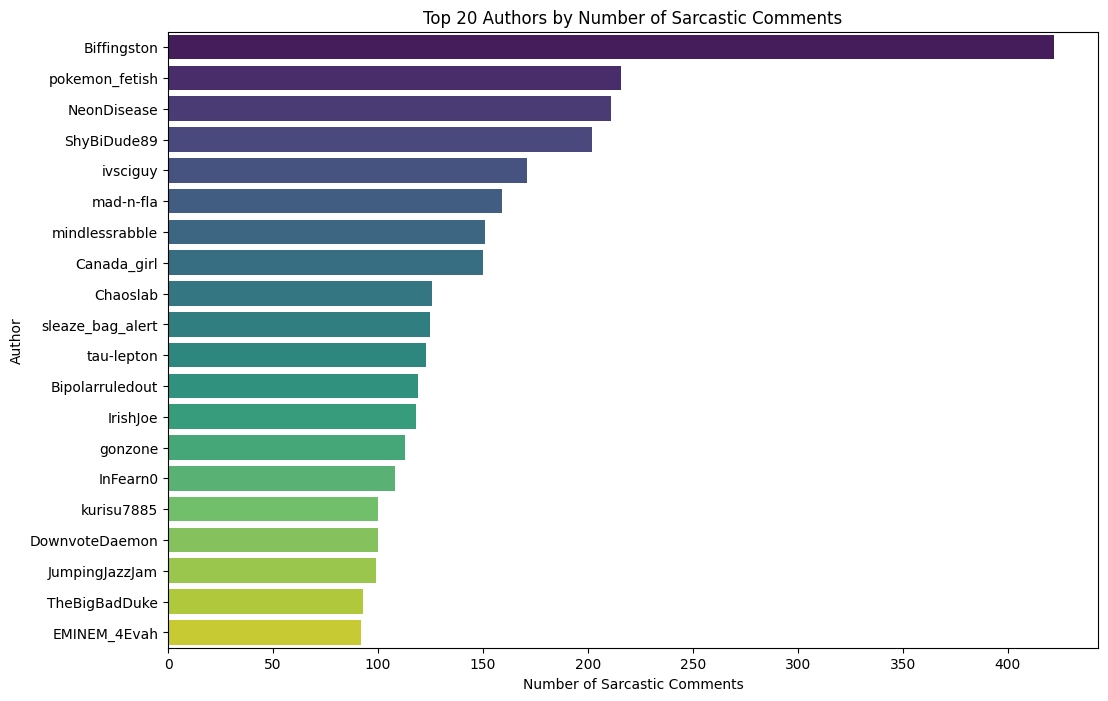

In [ ]:
# Function to plot author-based sarcasm distribution
def plot_author_sarcasm_distribution(df):
    # Filter sarcastic comments
    sarcastic_comments = df[df['label'] == 1]
    # Count the number of sarcastic comments per author
    author_counts = sarcastic_comments['author'].value_counts().head(20)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=author_counts.values, y=author_counts.index, hue=author_counts.index, palette='viridis')
    plt.title('Top 20 Authors by Number of Sarcastic Comments')
    plt.xlabel('Number of Sarcastic Comments')
    plt.ylabel('Author')
    plt.show()

# Call the function
plot_author_sarcasm_distribution(df)

In [ ]:
# Function to examine sarcastic comments by author
def sample_sarcastic_comments_by_author(df, author_name, n=5):
    # Filter for sarcastic comments by the specified author
    author_comments = df[(df['label'] == 1) & (df['author'] == author_name)]

    # Check if the specified author has any sarcastic comments
    if author_comments.empty:
        print(f"No sarcastic comments found for author: {author_name}")
        return

    # If the author has fewer comments than requested, adjust n accordingly
    n = min(n, len(author_comments))

    # Sample n sarcastic comments from the specified author (or all if fewer than n)
    sample_comments = author_comments.sample(n)

    # Display the author and the sampled comments
    print(f"Author: {author_name}\nSampled sarcastic comments:\n")
    for index, row in sample_comments.iterrows():
        print(f"- {row['comment']}\n")

# Call the function
sample_sarcastic_comments_by_author(df, 'Biffingston')

Author: Biffingston
Sampled sarcastic comments:

- You can tell by the pixels right?

- Hello, you must be new to this subreddit.

- Damnit China, we did it first!

- Because it doesn't support what he wants it too, duh.

- Biotrufs..dickwad.



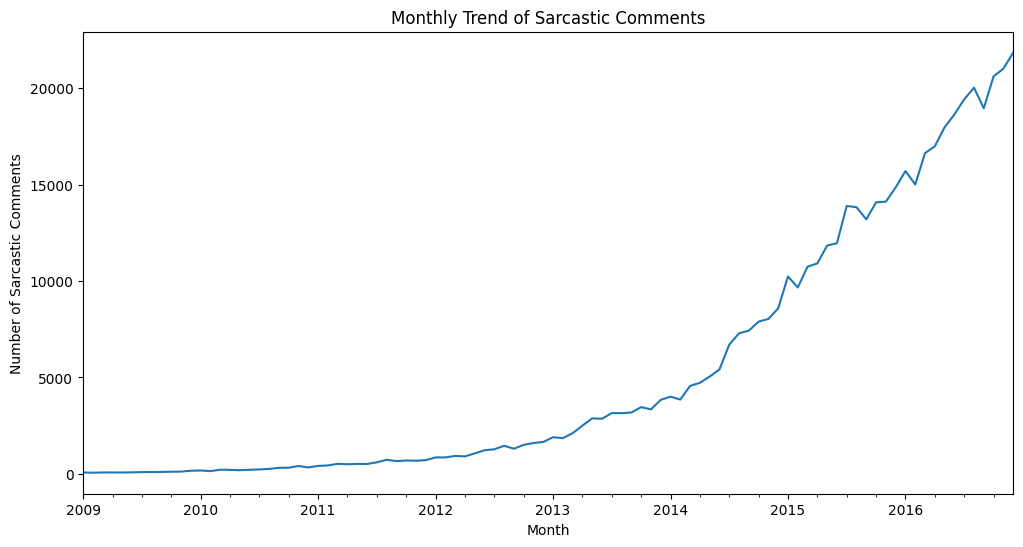

In [ ]:
# Function to plot temporal trends in sarcastic comments
def plot_sarcasm_trends_over_time(df):
    # Convert created_utc to datetime
    df['created_datetime'] = pd.to_datetime(df['created_utc'])
    # Resample to monthly frequency and count the number of sarcastic comments
    monthly_sarcasm = df[df['label'] == 1].resample('M', on='created_datetime').count()['label']

    plt.figure(figsize=(12, 6))
    monthly_sarcasm.plot()
    plt.title('Monthly Trend of Sarcastic Comments')
    plt.xlabel('Month')
    plt.ylabel('Number of Sarcastic Comments')
    plt.show()

# Call the function
plot_sarcasm_trends_over_time(df)

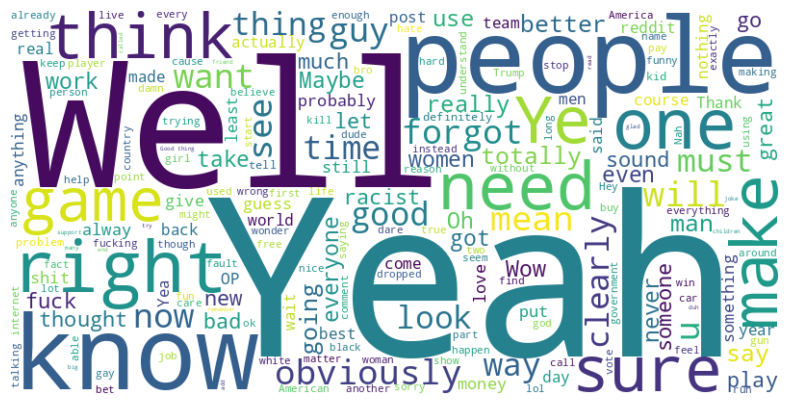

In [ ]:
# Function to create word cloud
def generate_wordcloud(texts):
    # Combine all texts into one large string
    combined_text = " ".join(texts)

    # Generate a word cloud image
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(combined_text)

    # Display the generated image
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Call the function
generate_wordcloud(df[df['label'] == 1]['comment'])

# Preprocessing the Data

## Splitting the Data

In [ ]:
# Define the features and labels
X = df['comment']
y = df['label']

In [ ]:
# Split the data into training and temporary set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

# Print the sizes
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 808618
Validation set size: 101077
Test set size: 101078


## TensorFlow Datasets

In [ ]:
# Function to clean the text
def clean_text(text):
    # Lowercase the text
    text = tf.strings.lower(text)

    # Remove digits
    text = tf.strings.regex_replace(text, r'\d+', '')

    # Remove punctuation
    text = tf.strings.regex_replace(text, '[%s]' % re.escape(string.punctuation), '')

    # Remove symbols
    symbol_pattern = ("["
                     u"\U0001F600-\U0001F64F"  # emoticons
                     u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                     u"\U000024C2-\U0001F251"  # additional symbols
                     "]+")
    text = tf.strings.regex_replace(text, symbol_pattern, "")

    # Replace multiple whitespaces with a single space
    text = tf.strings.regex_replace(text, r'\s+', ' ')

    # Trim whitespaces at the beginning and the end
    text = tf.strings.strip(text)

    return text

In [ ]:
# Parameters for the model and dataset
vocab_size = 20000
max_length = 100
batch_size = 128

In [ ]:
# Initialize the TextVectorization layer
vectorize_layer = keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=max_length,
    standardize=clean_text
)

# Adapt the TextVectorization layer on the training data
train_texts = tf.data.Dataset.from_tensor_slices(X_train).batch(batch_size)
vectorize_layer.adapt(train_texts)

In [ ]:
# Function to vectorize the text
def vectorize_text(text, label):
    text = vectorize_layer(text)
    return text, label

# Function to create a TensorFlow Dataset
def make_dataset(X, y, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.padded_batch(batch_size, padded_shapes=([None], []))
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Create the datasets
train_dataset = make_dataset(X_train, y_train, shuffle=True)
val_dataset = make_dataset(X_val, y_val)
test_dataset = make_dataset(X_test, y_test)

In [ ]:
# Print the dataset sizes
print(f"Training set size: {len(train_dataset)} batches")
print(f"Validation set size: {len(val_dataset)} batches")
print(f"Test set size: {len(test_dataset)} batches")

Training set size: 6318 batches
Validation set size: 790 batches
Test set size: 790 batches


## Creating Subsets

In [ ]:
# Function to create random, stratified subsets
def create_stratified_subsets(X_train, y_train, X_val, y_val, X_test, y_test, subset_size):
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=subset_size, random_state=SEED)

    # Create stratified subset for the training dataset
    _, train_subset_idx = next(splitter.split(X_train, y_train))
    X_train_subset, y_train_subset = X_train.iloc[train_subset_idx], y_train.iloc[train_subset_idx]

    # Create stratified subset for the validation dataset
    _, val_subset_idx = next(splitter.split(X_val, y_val))
    X_val_subset, y_val_subset = X_val.iloc[val_subset_idx], y_val.iloc[val_subset_idx]

    # Create stratified subset for the test dataset
    _, test_subset_idx = next(splitter.split(X_test, y_test))
    X_test_subset, y_test_subset = X_test.iloc[test_subset_idx], y_test.iloc[test_subset_idx]

    return X_train_subset, y_train_subset, X_val_subset, y_val_subset, X_test_subset, y_test_subset

# Call the function
X_train_subset, y_train_subset, X_val_subset, y_val_subset, X_test_subset, y_test_subset = create_stratified_subsets(
    X_train, y_train, X_val, y_val, X_test, y_test, subset_size=0.01
)

In [ ]:
# Print the subset sizes
print(f"Training subset size: {len(X_train_subset)}")
print(f"Validation subset size: {len(X_val_subset)}")
print(f"Test subset size: {len(X_test_subset)}")

Training subset size: 8087
Validation subset size: 1011
Test subset size: 1011


In [ ]:
# Initialize the TextVectorization layer
vectorize_layer_subset = keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=max_length,
    standardize=clean_text
)

# Adapt the TextVectorization layer on the training subset
train_texts_subset = tf.data.Dataset.from_tensor_slices(X_train_subset).batch(batch_size)
vectorize_layer_subset.adapt(train_texts_subset)

In [ ]:
# Function to vectorize the text
def vectorize_text_subset(text, label):
    text = vectorize_layer_subset(text)
    return text, label

# Function to create a TensorFlow Dataset
def make_dataset_subset(X, y, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.map(vectorize_text_subset, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.padded_batch(batch_size, padded_shapes=([None], []))
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Create the subsets
train_dataset_subset = make_dataset_subset(X_train_subset, y_train_subset, shuffle=True)
val_dataset_subset = make_dataset_subset(X_val_subset, y_val_subset)
test_dataset_subset = make_dataset_subset(X_test_subset, y_test_subset)

In [ ]:
# Print the subset sizes
print(f"Training subset size: {len(train_dataset_subset)} batches")
print(f"Validation subset size: {len(val_dataset_subset)} batches")
print(f"Test subset size: {len(test_dataset_subset)} batches")

Training subset size: 64 batches
Validation subset size: 8 batches
Test subset size: 8 batches


# Building the Model

In [ ]:
# GPU specification
USE_GPU = True

In [ ]:
# Get angles function
def get_angles(pos, i, embed_dim):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(embed_dim))
  return pos * angle_rates

# Positional encoding function
def positional_encoding(position, embed_dim):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(embed_dim)[np.newaxis, :],
                          embed_dim)

  # Apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # Apply cos to odd indices in the array; 2i + 1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

# Padding mask function
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # Add extra dimensions to add the padding to the attention logits
  return seq[:, tf.newaxis, tf.newaxis, :]  # [batch_size, 1, 1, seq_len]

# Look-ahead mask function
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # [seq_len, seq_len]

# Scaled dot product attention function
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # [..., seq_len_q, seq_len_k]
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = tf.cast(matmul_qk, dtype=tf.float32) / tf.math.sqrt(dk)

    if mask is not None:
        mask = tf.cast(mask, tf.float32)
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, tf.cast(v, dtype=tf.float32))
    return output, attention_weights

In [ ]:
# MultiHeadAttentionBase class
class MultiHeadAttentionBase(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttentionBase, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim

        assert embed_dim % self.num_heads == 0

        self.depth = embed_dim // self.num_heads

        self.wq = None
        self.wk = None
        self.wv = None
        self.dense = None

    def split_heads(self, x, batch_size):
        """
        - Split the last dimension into [num_heads, depth]
        - Transpose the result to [batch_size, num_heads, seq_len, depth]
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def apply_dense_layers(self, v, k, q):
        raise NotImplementedError("Base class does not implement apply_dense_layers() function")

    def apply_combine_heads(self, x):
        raise NotImplementedError("Base class does not implement apply_combine_heads() function")

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        v, k, q = self.apply_dense_layers(v, k, q)

        q = self.split_heads(q, batch_size)  # [batch_size, num_heads, seq_len_q, depth]
        k = self.split_heads(k, batch_size)  # [batch_size, num_heads, seq_len_k, depth]
        v = self.split_heads(v, batch_size)  # [batch_size, num_heads, seq_len_v, depth]

        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # [batch_size, seq_len_q, num_heads, depth]

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embed_dim))  # [batch_size, seq_len_q, embed_dim]

        output = self.apply_combine_heads(concat_attention) # [batch_size, seq_len_q, embed_dim]
        return output, attention_weights

# MultiHeadAttentionClassical class
class MultiHeadAttentionClassical(MultiHeadAttentionBase):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttentionClassical, self).__init__(embed_dim, num_heads)
        self.wq = tf.keras.layers.Dense(embed_dim)
        self.wk = tf.keras.layers.Dense(embed_dim)
        self.wv = tf.keras.layers.Dense(embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim)

    def apply_dense_layers(self, v, k, q):
        q = self.wq(q)  # [batch_size, seq_len, embed_dim]
        k = self.wk(k)  # [batch_size, seq_len, embed_dim]
        v = self.wv(v)  # [batch_size, seq_len, embed_dim]

        return v, k, q

    def apply_combine_heads(self, x):
        return self.dense(x)  # [batch_size, seq_len_q, embed_dim]

# MultiHeadAttentionQuantum class
class MultiHeadAttentionQuantum(MultiHeadAttentionBase):
    def __init__(self,
                 embed_dim, num_heads,
                 n_qubits, n_qlayers=1, q_device='default.qubit'):
        super(MultiHeadAttentionQuantum, self).__init__(embed_dim, num_heads)

        assert n_qubits == embed_dim, f"Number of qubits ({n_qubits}) does not match embedding dim ({embed_dim})"
        self.dev = qml.device(q_device, wires=n_qubits)

        def _circuit(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
            qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
            return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

        self.qlayer = qml.QNode(_circuit, self.dev, interface="tf")
        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.wq = qml.qnn.KerasLayer(self.qlayer, weight_shapes, output_dim=n_qubits)
        self.wk = qml.qnn.KerasLayer(self.qlayer, weight_shapes, output_dim=n_qubits)
        self.wv = qml.qnn.KerasLayer(self.qlayer, weight_shapes, output_dim=n_qubits)
        self.dense = qml.qnn.KerasLayer(self.qlayer, weight_shapes, output_dim=n_qubits)

    def apply_dense_layers(self, v, k, q):
        # Define the TensorFlow function to be applied to each timestep
        def apply_layer(x, layer):
            return layer(x)

        # Define the output signature of the map_fn operation
        fn_output_signature = tf.TensorSpec(shape=(None, self.embed_dim), dtype=tf.float64)

        # Use tf.map_fn to apply quantum layers to each timestep
        q = tf.map_fn(lambda x: apply_layer(x, self.wq), q, fn_output_signature=fn_output_signature)
        k = tf.map_fn(lambda x: apply_layer(x, self.wk), k, fn_output_signature=fn_output_signature)
        v = tf.map_fn(lambda x: apply_layer(x, self.wv), v, fn_output_signature=fn_output_signature)

        return v, k, q

    def apply_combine_heads(self, x):
        # Define the output signature of the map_fn operation for combine heads
        fn_output_signature = tf.TensorSpec(shape=(None, self.embed_dim), dtype=tf.float64)

        # Use tf.map_fn to apply the dense layer to the combined heads
        x = tf.map_fn(lambda x: self.dense(x), x, fn_output_signature=fn_output_signature)

        return x

In [ ]:
# FFN Classical class
class FeedForwardNetworkClassical(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dff, **kwargs):
        super(FeedForwardNetworkClassical, self).__init__(**kwargs)
        self.dense1 = tf.keras.layers.Dense(dff, activation='relu')
        self.dense2 = tf.keras.layers.Dense(embed_dim)

    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

# FFN Quantum class
class FeedForwardNetworkQuantum(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dff, n_qubits_ffn, n_qlayers=1, q_device='default.qubit', **kwargs):
        super(FeedForwardNetworkQuantum, self).__init__(**kwargs)
        self.dense1 = tf.keras.layers.Dense(dff, activation='relu')
        self.dense2 = tf.keras.layers.Dense(embed_dim)

    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

# TransformerBlockBase class
class TransformerBlockBase(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, dff, dropout_rate=0.1):
        super(TransformerBlockBase, self).__init__()
        self.mha = None
        self.ffn = None

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # [batch_size, input_seq_len, embed_dim]
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # [batch_size, input_seq_len, embed_dim]

        ffn_output = self.ffn(out1)  # [batch_size, input_seq_len, embed_dim]
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # [batch_size, input_seq_len, embed_dim]

        return out2

# TransformerBlockClassical class
class TransformerBlockClassical(TransformerBlockBase):
    def __init__(self, embed_dim, num_heads, dff, dropout_rate=0.1):
        super(TransformerBlockClassical, self).__init__(embed_dim, num_heads, dff, dropout_rate)
        self.mha = MultiHeadAttentionClassical(embed_dim, num_heads)
        self.ffn = FeedForwardNetworkClassical(embed_dim, dff)

# TransformerBlockQuantum class
class TransformerBlockQuantum(TransformerBlockBase):
    def __init__(self,
                 embed_dim, num_heads, dff, dropout_rate=0.1,
                 n_qubits_transformer: int = 0,
                 n_qubits_ffn: int = 0,
                 n_qlayers: int = 1,
                 q_device='default.qubit'):
        super(TransformerBlockQuantum, self).__init__(embed_dim, num_heads, dff, dropout_rate)
        self.mha = MultiHeadAttentionQuantum(embed_dim, num_heads, n_qubits_transformer, n_qlayers, q_device)
        self.ffn = FeedForwardNetworkQuantum(embed_dim, dff, n_qubits_ffn, n_qlayers, q_device)

In [ ]:
# EncoderLayerBase class
class EncoderLayerBase(tf.keras.layers.Layer):
    def __init__(self,
                num_layers,
                embed_dim,
                num_heads,
                dff,
                vocab_size,
                maximum_position_encoding,
                dropout_rate=0.1):
        super(EncoderLayerBase, self).__init__()

        self.embed_dim = embed_dim
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embed_dim)
        self.enc_layers = None
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training, mask=None):

        seq_len = tf.shape(x)[1]

        # Adding embedding and position encoding
        x = self.embedding(x)  # [batch_size, input_seq_len, embed_dim]
        x *= tf.math.sqrt(tf.cast(self.embed_dim, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # [batch_size, input_seq_len, embed_dim]

# EncoderLayerClassical class
class EncoderLayerClassical(EncoderLayerBase):
    def __init__(self,
                num_layers,
                embed_dim,
                num_heads,
                dff,
                vocab_size,
                maximum_position_encoding,
                dropout_rate=0.1):
        super(EncoderLayerClassical, self).__init__(num_layers, embed_dim, num_heads, dff, vocab_size, maximum_position_encoding, dropout_rate)

        self.enc_layers = [TransformerBlockClassical(embed_dim, num_heads, dff, dropout_rate)
                        for _ in range(num_layers)]

# EncoderLayerQuantum class
class EncoderLayerQuantum(EncoderLayerBase):
    def __init__(self,
                num_layers,
                embed_dim,
                num_heads,
                dff,
                vocab_size,
                maximum_position_encoding,
                dropout_rate=0.1,
                n_qubits_transformer: int = 0,
                n_qubits_ffn: int = 0,
                n_qlayers: int = 1,
                q_device='device.qubit'):
        super(EncoderLayerQuantum, self).__init__(num_layers, embed_dim, num_heads, dff, vocab_size, maximum_position_encoding, dropout_rate)
        self.enc_layers = [TransformerBlockQuantum(embed_dim, num_heads, dff, dropout_rate,
                                                   n_qubits_transformer, n_qubits_ffn, n_qlayers, q_device)
                            for _ in range(num_layers)]

In [ ]:
# TextClassifierTF class
class TextClassifierTF(tf.keras.Model):
    def __init__(self,
                num_layers,
                embed_dim,
                num_heads,
                dff,
                vocab_size,
                num_classes,
                maximum_position_encoding: int=10000,
                dropout_rate=0.1,
                n_qubits_transformer: int = 0,
                n_qubits_ffn: int = 0,
                n_qlayers: int = 1,
                q_device='device.qubit'):
        super(TextClassifierTF, self).__init__()

        if n_qubits_transformer == 0 and n_qubits_ffn == 0:
            self.encoder = EncoderLayerClassical(num_layers, embed_dim, num_heads, dff,
                            vocab_size, maximum_position_encoding, dropout_rate)
        else:
            self.encoder = EncoderLayerQuantum(num_layers, embed_dim, num_heads, dff,
                            vocab_size, maximum_position_encoding, dropout_rate,
                            n_qubits_transformer, n_qubits_ffn, n_qlayers, q_device)

        if num_classes < 2:
            raise RuntimeError("Number of classes must be at least 2")
        elif num_classes == 2:
            self.final_layer = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
        else:
            self.final_layer = tf.keras.layers.Dense(num_classes, activation=tf.keras.activations.softmax)

    def call(self, x, training):
        encoded_output = self.encoder(x, training)  # [batch_size, inp_seq_len, embed_dim]
        pooled_output = encoded_output[:,0,:]
        final_output = self.final_layer(pooled_output)  # [batch_size, tar_seq_len, num_classes]

        return final_output

# Training the Model

In [ ]:
# Set model arguments
q_device = 'default.qubit'
batch_size = 128
n_epochs = 5
n_classes = 2
lr = 0.001
vocab_size = 20000
embed_dim = 2
max_seq_len = 100
ffn_dim = 8
n_transformer_blocks = 2
n_heads = 2
n_qubits_transformer = 2
n_qubits_ffn = 2
n_qlayers = 2
dropout_rate = 0.1
maximum_position_encoding = 1024

In [ ]:
# Initialize the model
tf_model = TextClassifierTF(
    num_layers=n_transformer_blocks,
    embed_dim=embed_dim,
    num_heads=n_heads,
    dff=ffn_dim,
    vocab_size=vocab_size,
    num_classes=n_classes,
    maximum_position_encoding=maximum_position_encoding,
    dropout_rate=dropout_rate,
    n_qubits_transformer=n_qubits_transformer,
    n_qubits_ffn=n_qubits_ffn,
    n_qlayers=n_qlayers,
    q_device=q_device
)

weight_shapes = (n_qlayers, n_qubits) = (2, 2)
weight_shapes = (n_qlayers, n_qubits) = (2, 2)


In [ ]:
# Compile the model
tf_model.compile(optimizer='adam',
                 loss=keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])

In [ ]:
# Set up checkpoint callback
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'best_model.tf',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

In [ ]:
# Train the model
tf_history = tf_model.fit(train_dataset_subset,
                          epochs=n_epochs,
                          validation_data=val_dataset_subset,
                          batch_size=batch_size,
                          callbacks=[checkpoint_cb],
                          verbose=1)

Epoch 1/5
64/64 [==============================] - ETA: 0s - loss: 0.7775 - accuracy: 0.4992 

64/64 [==============================] - 3410s 53s/step - loss: 0.7775 - accuracy: 0.4992 - val_loss: 0.7434 - val_accuracy: 0.5005
Epoch 2/5
64/64 [==============================] - ETA: 0s - loss: 0.7297 - accuracy: 0.5012 

64/64 [==============================] - 3449s 54s/step - loss: 0.7297 - accuracy: 0.5012 - val_loss: 0.7101 - val_accuracy: 0.5005
Epoch 3/5
64/64 [==============================] - ETA: 0s - loss: 0.7123 - accuracy: 0.4950 

64/64 [==============================] - 3527s 55s/step - loss: 0.7123 - accuracy: 0.4950 - val_loss: 0.6972 - val_accuracy: 0.5005
Epoch 4/5
64/64 [==============================] - ETA: 0s - loss: 0.7009 - accuracy: 0.5025 

64/64 [==============================] - 3489s 55s/step - loss: 0.7009 - accuracy: 0.5025 - val_loss: 0.6940 - val_accuracy: 0.5005
Epoch 5/5
64/64 [==============================] - ETA: 0s - loss: 0.7001 - accuracy: 0.4983 

64/64 [==============================] - 3477s 54s/step - loss: 0.7001 - accuracy: 0.4983 - val_loss: 0.6933 - val_accuracy: 0.5005


In [ ]:
import shutil
from google.colab import files

# Download the model
shutil.make_archive('best_model', 'zip', 'best_model.tf')
files.download('best_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Plotting the History

In [ ]:
# Load the best model
best_model = keras.models.load_model('best_model.tf')

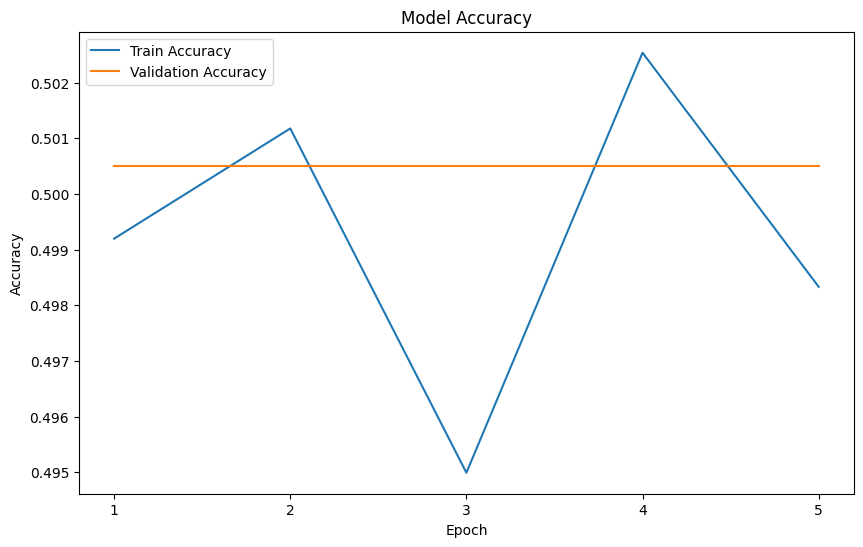

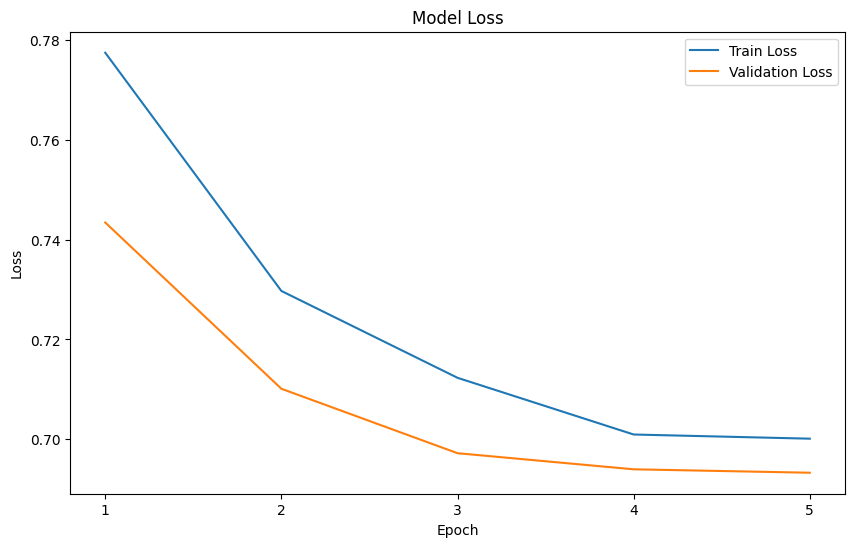

In [ ]:
# Function to plot the training history
def plot_accuracy_and_loss(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot training & validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(epochs)
    plt.legend(loc='upper left')
    plt.show()

    # Plot training & validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(epochs)
    plt.legend(loc='upper right')
    plt.show()

# Call the function
plot_accuracy_and_loss(tf_history)

# Evaluating the Model

In [ ]:
# Function to evaluate model performance
def evaluate_model(model, dataset, is_binary_classification=True, threshold=0.5):
    y_true = []
    y_pred_proba = []

    for batch in dataset:
        inputs, labels = batch
        preds = model.predict(inputs)

        y_true.extend(labels.numpy())
        y_pred_proba.extend(preds)

    y_true = np.array(y_true)
    y_pred_proba = np.array(y_pred_proba)

    if is_binary_classification:
        # Convert probabilities to binary predictions based on the threshold
        y_pred = (y_pred_proba > threshold).astype(int)
    else:
        # For multi-class classification, take the argmax as the predicted class
        y_pred = np.argmax(y_pred_proba, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro')
    if is_binary_classification:
        roc_auc = roc_auc_score(y_true, y_pred_proba)
    else:
        # For multi-class, use a "one vs. all" approach for ROC-AUC
        roc_auc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')

    metrics = {
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1,
        'ROC-AUC': roc_auc
    }

    return metrics

# Call the function
metrics = evaluate_model(best_model, test_dataset_subset, is_binary_classification=True, threshold=0.5)
for metric, value in metrics.items():
    print(f'{metric}: {value:.4f}')

Accuracy: 0.5005
Recall: 0.5000
Precision: 0.2502
F1 Score: 0.3336
ROC-AUC: 0.4980


# Inferencing Demo

In [ ]:
# Function for inferencing
def predict_on_text(text, model, threshold=0.5):
    # Preprocess and vectorize the input text
    clean_text_input = clean_text(text)
    vectorized_text = vectorize_layer(tf.convert_to_tensor([clean_text_input]))

    # Perform prediction
    prediction = model.predict(vectorized_text)

    # Use the specified threshold for classification
    predicted_class_numeric = (prediction[0] > threshold).astype('int32')
    predicted_probability = prediction[0]

    # Map numeric class to label
    class_labels = {0: "Not sarcastic", 1: "Sarcastic"}
    predicted_class = class_labels[predicted_class_numeric[0]]

    return predicted_class, predicted_probability

# Call the function
input_text = "Wow, didn't know Einstein was in the chat."
predicted_class, predicted_probability = predict_on_text(input_text, best_model, threshold=0.5)
print(f"Predicted class: {predicted_class}, Predicted probability: {predicted_probability}")

Predicted class: Not sarcastic, Predicted probability: [0.49134466]


Potential Reasons for Model Failure:
- Low capacity: the number of layers, qubits, embedding dimensions, etc. were set low to avoid unmanageably long training times. Perhaps if we had more computational resources and increased these parameters, the model would demonstrate more promising performance.
- Data quantity: a very small subset (1%) of the data was used to avoid unfeasibly long training durations. Training with more data may lead to greater model performance.
- In sum: the settings and workarounds we have implemented to make the model runnable may have subsequently caused the model to exhibit such lackluster performance.